### 1. Laboratorio de la clase 1: Introducción y contexto

En este laboratorio vamos a aprender y a repasar conceptos básicos de limpieza, procesamiento y visualización de datos, así como la implementación de algunos algoritmos básicos de aprendizaje automático. En el primer ejercicio de este laboratorio, vamos a realizar una regresión polinómica usando datos generados artificialmente con la que aprenderemos y recordaremos conceptos básicos de aprendizaje automático tales como la división de datos entre datos de entrenamiento y de testeo. También vamos a evaluar el desempeño del modelo que construiremos, y finalmente vamos a usar técnicas de validación cruzada para encontrar los hiperparámetros óptimos para el modelo. Esta actividad corta nos brindará las bases conceptuales que usaremos en la segunda parte del laboratorio, en la cual usaremos un set de datos de la sección de telemercadeo de un banco, con el fin de predecir si la estrategia de telemercadeo del banco será eficiente en nuevos clientes.

### 2. Regresión polinómica

El objetivo de esta actividad es construir un modelo que, a partir de variables que no están linealmente relacionadas, nos permita hacer predicciones dados nuevos datos de entrada. Para lograr esto, empecemos importando las librerías que vamos a usar durante este ejercicio:

In [1]:
# Librerías necesarias 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor

Los datos que usaremos para entrenar el modelo los generamos de manera artificial, escogiendo una función (en este caso la función seno) y añadiendo ruido aleatorio:

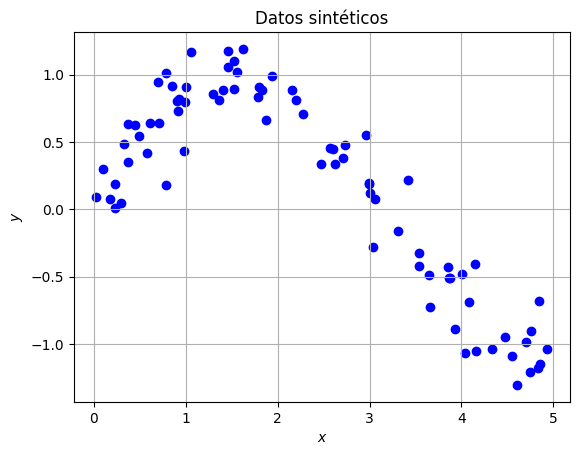

In [2]:
# Generación de datos sintéticos
np.random.seed(42)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.2, size=X.shape[0]) # El método ravel() aplana el array

# Visualización de los datos
plt.scatter(X, y, color='blue')
plt.grid()
plt.title('Datos sintéticos')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

Ahora procedemos a usar estos datos para crear el modelo. Para empezar, intentemos usar un modelo que sea un polinomio de segundo grado:

In [3]:
# Construcción del modelo incluyendo normalización de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
inner_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=2), LinearRegression())
model = TransformedTargetRegressor(regressor=inner_pipe, transformer=StandardScaler())
model.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('standardscaler',
                                                      StandardScaler()),
                                                     ('polynomialfeatures',
                                                      PolynomialFeatures()),
                                                     ('linearregression',
                                                      LinearRegression())]),
                           transformer=StandardScaler())

Habiendo entrenado el modelo, a continuación evaluamos su desempeño usando la métrica MSE. Para hacer esta evaluación, usamos el set de testeo.

Evalucación del modelo con polinomio de grado 2: MSE = 0.0835


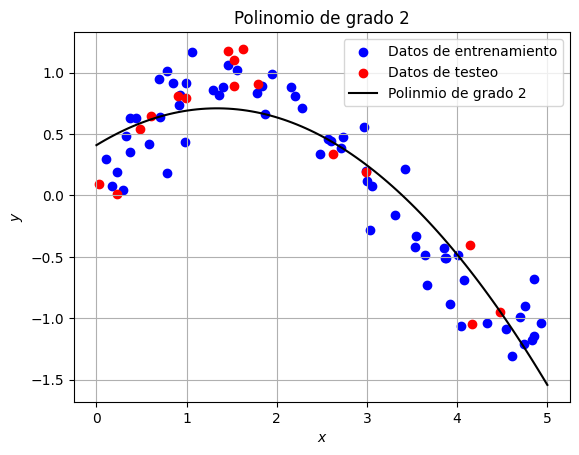

In [4]:
# Predicciones y evalucación del modelo usanndo el set de testeo y MSE
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Evalucación del modelo con polinomio de grado 2: MSE = {mse:.4f}")

# Visualización de los resultados
X_plot = np.linspace(0, 5, 100).reshape(-1, 1)
y_plot = model.predict(X_plot)
plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Datos de testeo')
plt.plot(X_plot, y_plot, color='black', label='Polinmio de grado 2')
plt.title(r"Polinomio de grado 2")
plt.grid()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

Se ve bien, pero podría mejorar... ¡Para ver el orden óptimo del polinomio que mejor se ajuste a los datos, podemos hacer validación cruzada!

Mejor grado de la validación cruzada: 4


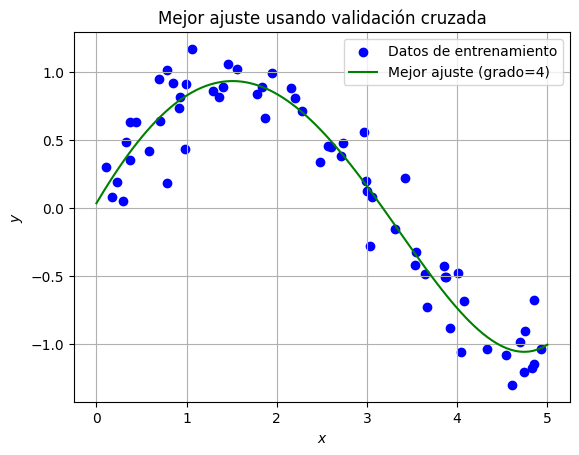

In [5]:
# Validación cruzada para encontrar el mejor grado del polinomio
param_grid = {'regressor__polynomialfeatures__degree': [1, 2, 3, 4, 5, 6, 7]}
base_pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LinearRegression())
model_cv = TransformedTargetRegressor(regressor=base_pipe, transformer=StandardScaler())

grid = GridSearchCV(model_cv, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_deg = grid.best_params_['regressor__polynomialfeatures__degree']
print("Mejor grado de la validación cruzada:", best_deg)

# Visualización del mejor ajuste
y_best = grid.predict(X_plot)
plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')
plt.plot(X_plot, y_best, color='green', label=f"Mejor ajuste (grado={best_deg})")
plt.title("Mejor ajuste usando validación cruzada")
plt.xlabel(r"$x$")
plt.grid()
plt.ylabel(r"$y$")
plt.legend()
plt.show()

Este es el final del primer ejercicio. Para seguir con el siguiente y que no hayan conflictos con nombres de variables en ejercicios posteriores, usamos el siguiente comando:

In [6]:
%reset -f

### 3. Estrategia de telemercadeo

En esta sección, usaremos algoritmos de aprendizaje automático para resolver un problema de clasificación: Dados datos de clientes de los cuales un banco dispone, tales como tipo de empleo, nivel de educación, mora y estado civil, ¿Podemos predecir si los clientes aceptarán o no suscribirse a un CDT? Para el desarrollo de este ejercicio, usaremos datos que están libremente disponibles en:

Moro, S., Cortez, P., & Rita, P. (2014). A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, 62, 22–31.
https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Este ejercicio lo vamos a solucionar usando tres algoritmos diferentes: Regresión logística, árboles de decisión y random forest. La idea es comparar el desempeño del modelo usando estos tres algoritmos.

Como antes, empezamos importando las librerías que vamos a necesitar que vamos a usar:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Ahora cargamos los datos y visualizamos los primeros valores de los diferentes features o características del set de datos usando la librería pandas. También exploramos diferentes valores estadísticos relevantes de los datos como los promedios, desviaciones estándar y diferentes percentiles.

In [8]:
# Cargar el dataset y mostrar las primeras filas
df = pd.read_csv("bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
# Visualización de valores estadísticos relevantes de los features numéricos
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Ya que tenemos una idea de cómo son los datos y qué quieren decir los features, podemos buscar valores nulos y eliminar duplicados que pueden afectar el modelo de forma negativa.

In [10]:
# Buscar valores nulos y eliminando duplicados en el set de datos
df.drop_duplicates(inplace=True)
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

¡Hoy tuvimos suerte!

 No hay valores nulos en este set de datos. Sin embargo, en las situaciones que sí los hay, es necesario lidiar con ellos de alguna forma. Por ejemplo, si hay datos numéricos que sean nulos, estos deberían ser cambiados por valores como la media, mediana o moda, dependiendo del atributo. Para datos categóricos, uno podría reemplazar los datos nulos usando majority vote o creando nuevas categorías. 
 
 Sin embargo, aunque no hay datos nulos, para mejorar el desempeño de los modelos que vamos a usar, podemos buscar features redundantes que podamos omitir para construir el modelo. Este tipo de features, que no da información relevante, pueden ser constantes (hay un valor único para todos los datos del feature), casi constantes (el mismo valor aparece en la gran myoría de datos) o puede haber features altamente correlacionados, los cuales den información casi idéntica. Para buscar este tipo de features, definimos la siguiente función.

In [11]:
# Función para identificar features redundantes
def identify_redundant_features(df, quasi_constant_threshold=0.90, correlation_threshold=0.90):
    results = {}

    # Constantes
    constant_features = [col for col in df.columns if df[col].nunique() == 1]
    results['constant'] = constant_features

    # Casi constantes (quasi-constant)
    quasi_constant = []
    for col in df.columns:
        top_freq = df[col].value_counts(normalize=True).values[0]
        if top_freq > quasi_constant_threshold:
            quasi_constant.append(col)
    results['quasi_constant'] = list(set(quasi_constant) - set(constant_features))

    # Altamente correlacionados
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    correlated_pairs = [
        (row, col, upper.loc[row, col])
        for col in upper.columns
        for row in upper.index
        if not pd.isna(upper.loc[row, col]) and upper.loc[row, col] > correlation_threshold
    ]

    results['highly_correlated_pairs'] = correlated_pairs

    return results

In [12]:
redundant = identify_redundant_features(df)

for category, columns in redundant.items():
    print(f"{category} features:")
    for col in columns:
        print(f"  - {col}")


constant features:
quasi_constant features:
  - pdays
highly_correlated_pairs features:
  - ('emp.var.rate', 'euribor3m', np.float64(0.972243830979756))
  - ('emp.var.rate', 'nr.employed', np.float64(0.9069494985179554))
  - ('euribor3m', 'nr.employed', np.float64(0.9451459468620566))


Según este resultados, ¡Podemos eliminar el feature pdays, así como emp.var.rate, euribor3m y/o nr.employed!

In [13]:
# Eliminando las variables redundantes
df.drop(columns=['pdays', 'emp.var.rate', 'euribor3m'], inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,cons.price.idx,cons.conf.idx,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,0,nonexistent,93.994,-36.4,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,0,nonexistent,93.994,-36.4,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,0,nonexistent,93.994,-36.4,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,0,nonexistent,93.994,-36.4,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,0,nonexistent,93.994,-36.4,5191.0,no


Para identificar anomalías adicionales en los datos y ver si tenemos que procesarlos más, es útil graficarlos.

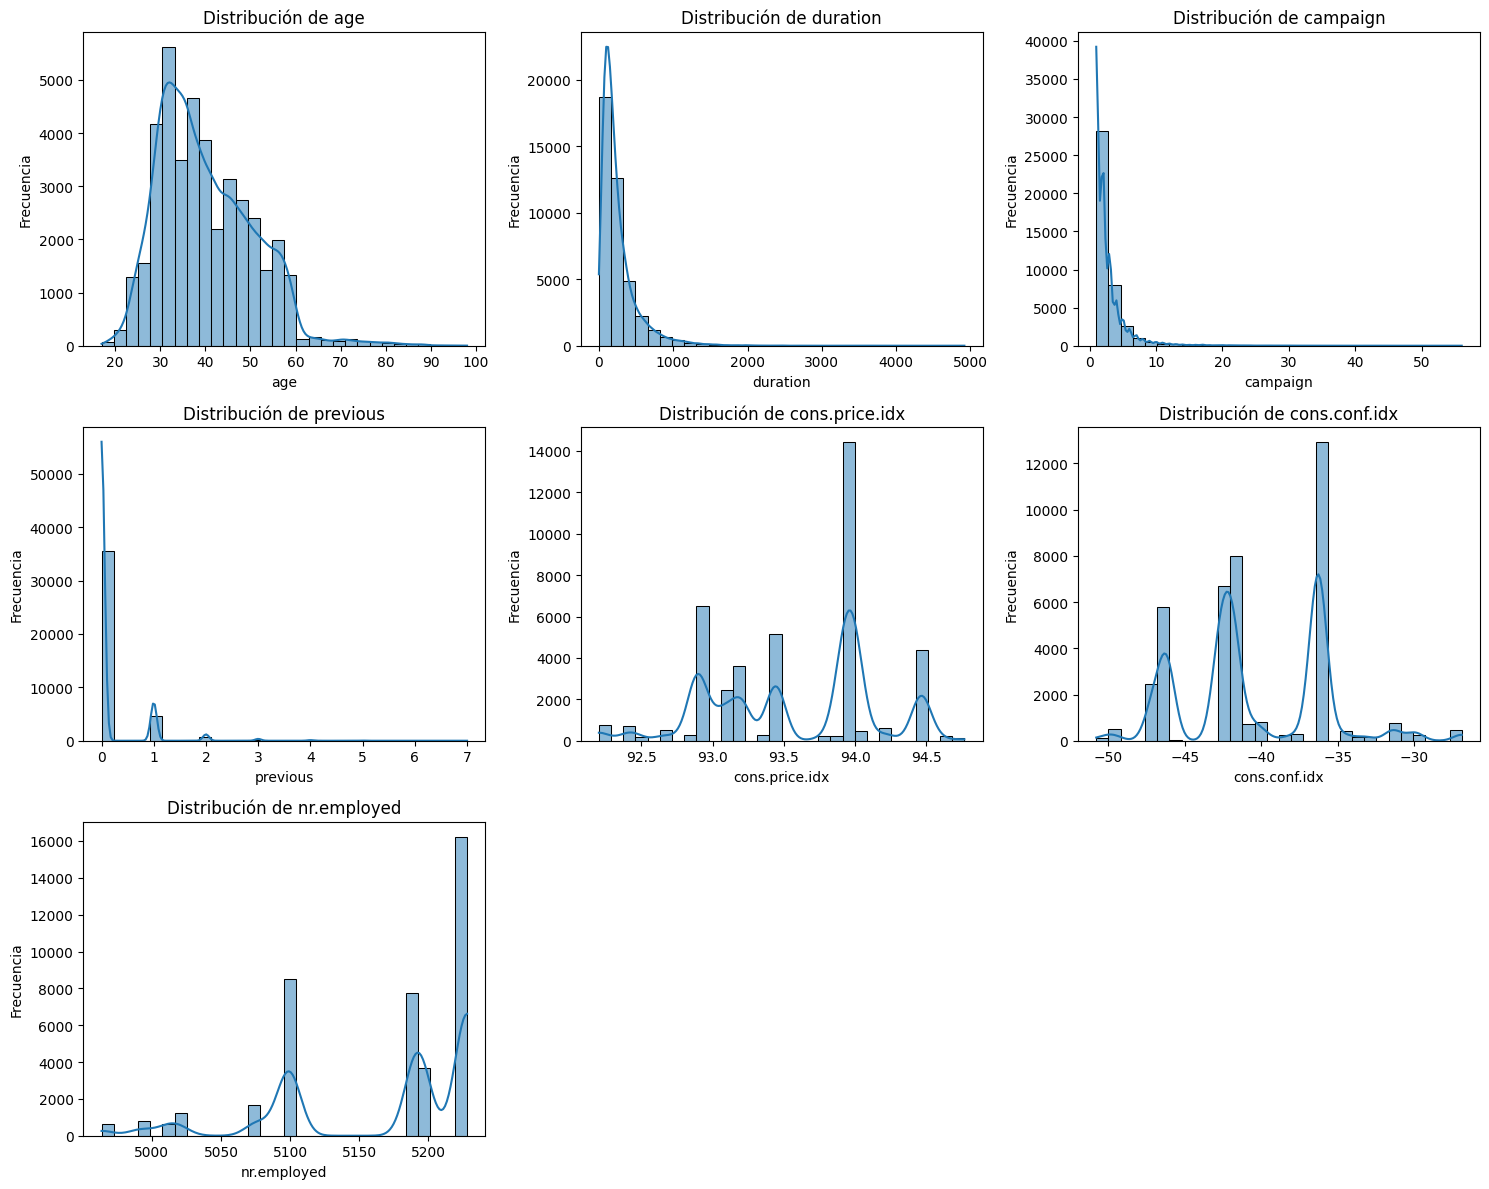

In [14]:
#Visuualización de features numéricos
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
n_num = len(numeric_cols)
ncols = 3
nrows = int(np.ceil(n_num / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

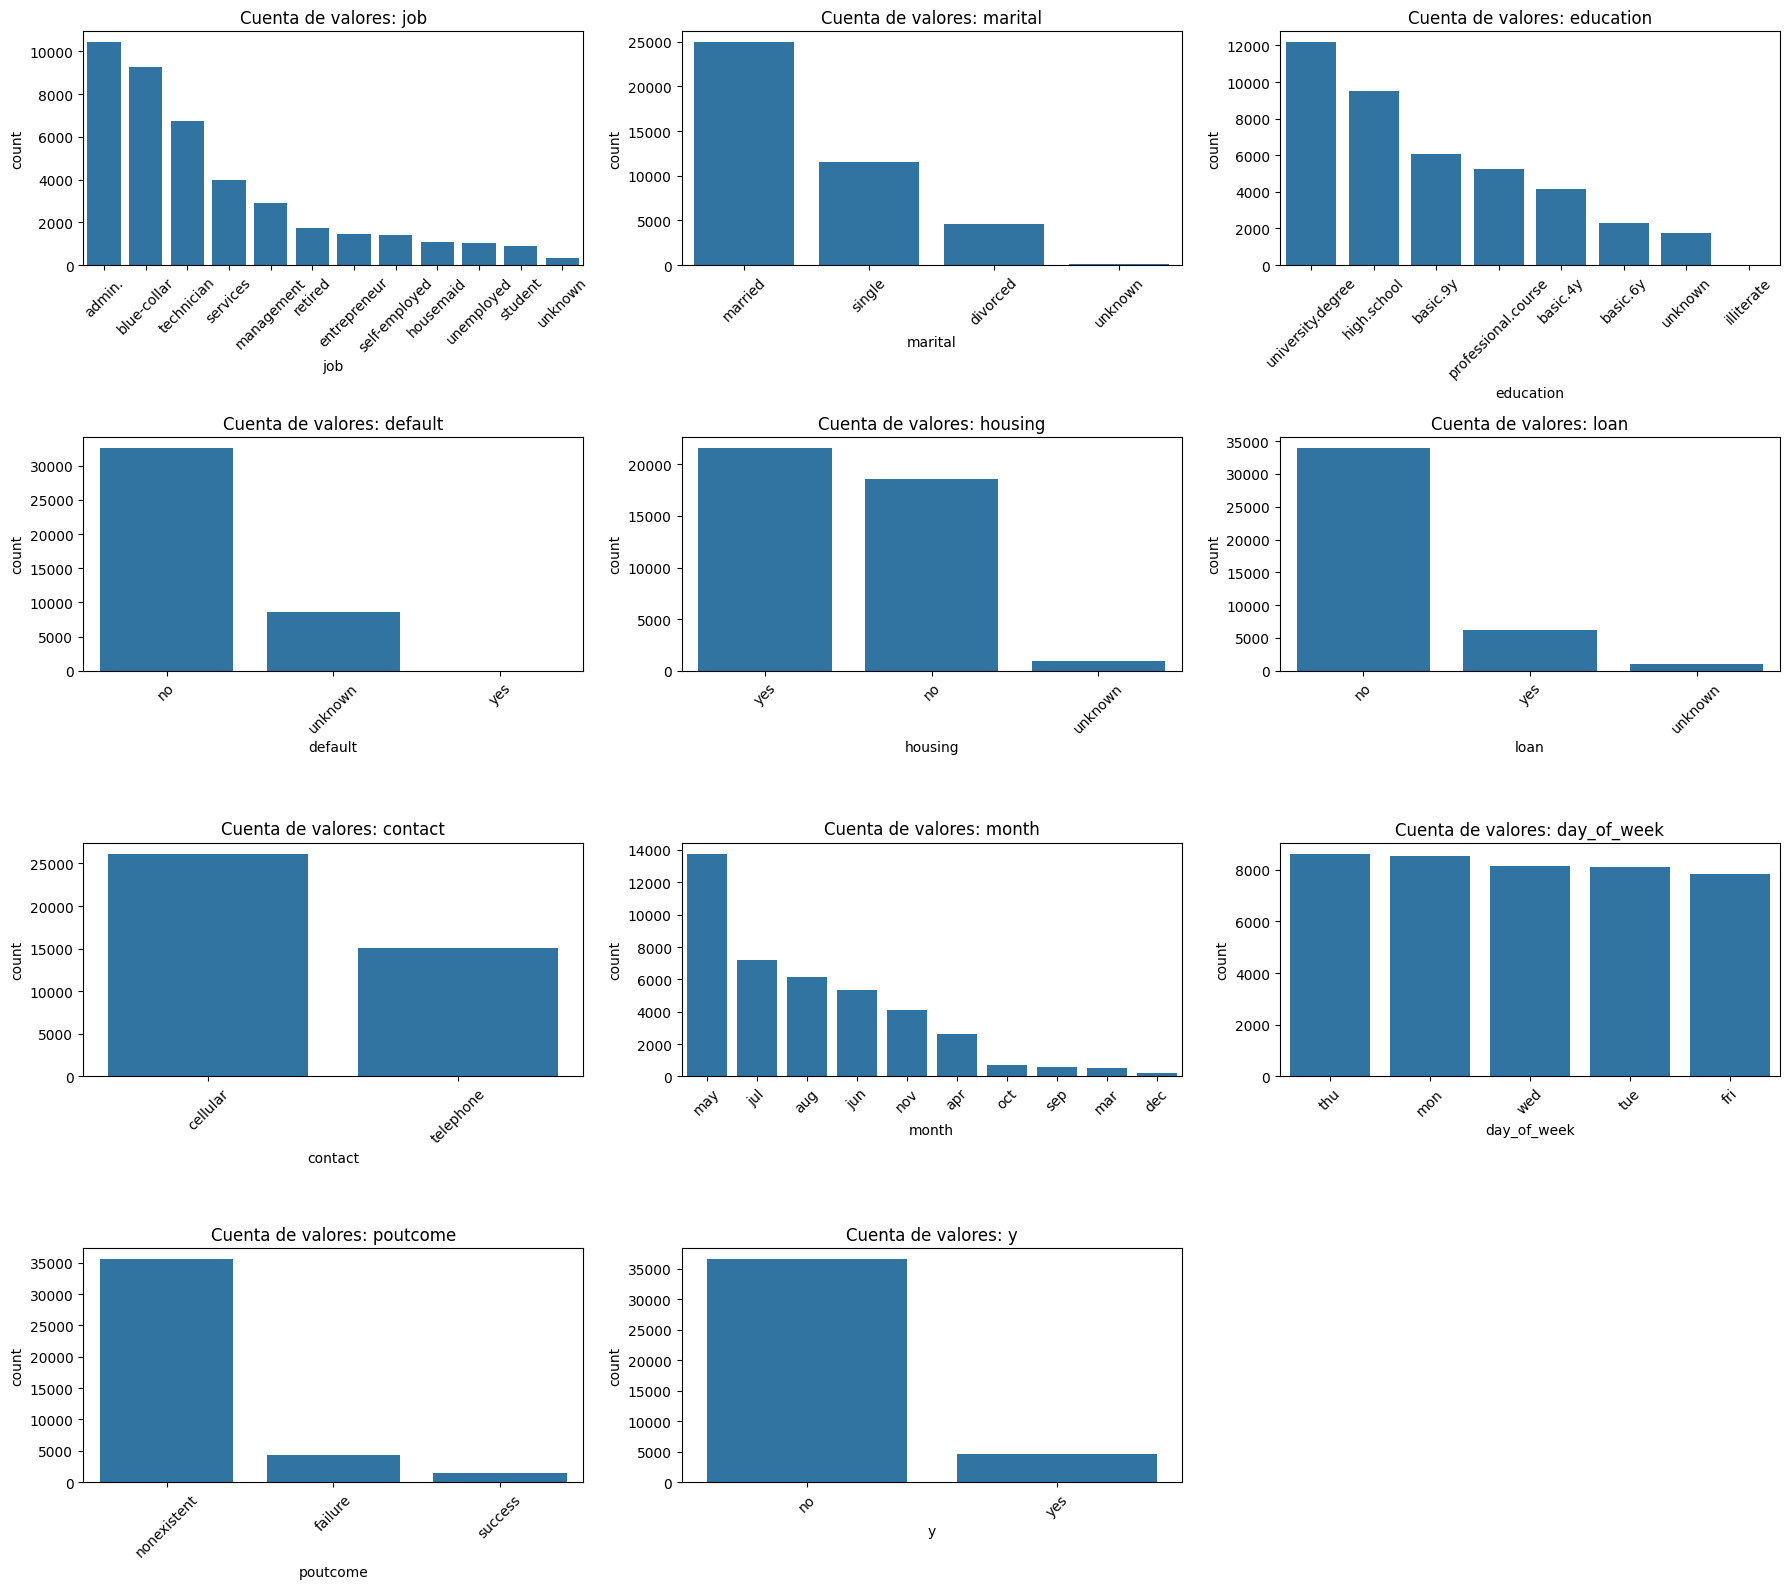

In [15]:
# Visualización de features categóricos
categorical_cols = df.select_dtypes(include='object').columns
n_cat = len(categorical_cols)
ncols = 3
nrows = int(np.ceil(n_cat / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Cuenta de valores: {col}")
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


No observamos ninguna anomalía y por lo tanto procedemos con la codificación de los datos categóricos y de la variable objetivo en datos numéricos. Para los features categóricos usaremos one-hot encoding. También separamos a continuación los datos en sets de entrenamiento y testeo.

In [16]:
# Codificación de variable respuesta y features categóricos
df['y'] = df['y'].map({'yes': 1, 'no': 0})
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separación de features y variable respuesta y creación de sets de entrenamiento y testeo
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

Teniendo todos los datos procesados y codificados en datos numéricos (o booleanos), seguimos con la construcción de los modelos basados en los algoritmos de regresión logísitica, árboles de decisión y random forest. Además, entrenamos estos modelos y los evaluamos usando métricas como el f1-score y accuracy.

In [17]:
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000)),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained.")

for name, model in models.items():
    print(f"\n=== {name} ===")
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

Logistic Regression trained.
Decision Tree trained.
Random Forest trained.

=== Logistic Regression ===
Accuracy: 0.9102719766877125
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      7308
           1       0.66      0.43      0.52       928

    accuracy                           0.91      8236
   macro avg       0.79      0.70      0.73      8236
weighted avg       0.90      0.91      0.90      8236


=== Decision Tree ===
Accuracy: 0.8847741622146673
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      7308
           1       0.49      0.50      0.49       928

    accuracy                           0.88      8236
   macro avg       0.71      0.72      0.71      8236
weighted avg       0.89      0.88      0.89      8236


=== Random Forest ===
Accuracy: 0.9091792132102963
Classification Report:
               precision    recall  f1

Aunque el modelo presenta un buen desempeño al predecir los casos negativos (clientes que no aceptan la propuesta del banco), su rendimiento es significativamente inferior al identificar correctamente los casos positivos. ¿A qué se puede deber esta asimetría? ¿El set de datos está balanceado en cuanto a la proporción de clases?

Cuentas por clase:
y
0    36537
1     4639
Name: count, dtype: int64

Proporción de clases:
y
0    0.887337
1    0.112663
Name: proportion, dtype: float64


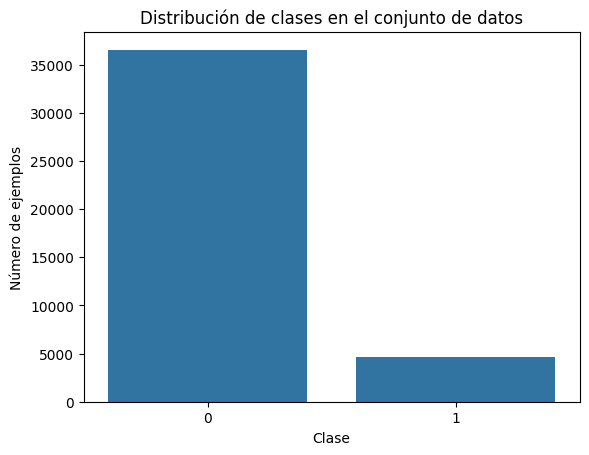

In [18]:
# Cheqeuo de balanceo de clases
print("Cuentas por clase:")
print(y.value_counts())
print("\nProporción de clases:")
print(y.value_counts(normalize=True))

sns.countplot(x=y)
plt.title("Distribución de clases en el conjunto de datos")
plt.xlabel("Clase")
plt.ylabel("Número de ejemplos")
plt.show()

Para lidiar con esto, usamos técnicas de re-sampling para mejorar la distribución de las clases y volvemos a entrenar los modelos con los datos más balanceados.

In [19]:
#Resampling para balancear clases y entrenmiento de modelos
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

resample_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.75, random_state=42)),  
    ('under', RandomUnderSampler(sampling_strategy=0.85, random_state=42)) 
])

X_resampled, y_resampled = resample_pipeline.fit_resample(X_train, y_train)

resampled_models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000)),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}
for name, resampled_model in resampled_models.items():
    resampled_model.fit(X_resampled, y_resampled)
    print(f"{name} trained.")

for name, resampled_model in resampled_models.items():
    print(f"\n=== {name} ===")
    y_pred_resampled = resampled_model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred_resampled))
    print("Classification Report:\n", classification_report(y_test, y_pred_resampled))

Logistic Regression trained.
Decision Tree trained.
Random Forest trained.

=== Logistic Regression ===
Accuracy: 0.9010441962117532
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94      7308
           1       0.56      0.58      0.57       928

    accuracy                           0.90      8236
   macro avg       0.75      0.76      0.76      8236
weighted avg       0.90      0.90      0.90      8236


=== Decision Tree ===
Accuracy: 0.8872025254978144
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      7308
           1       0.50      0.56      0.53       928

    accuracy                           0.89      8236
   macro avg       0.72      0.75      0.73      8236
weighted avg       0.89      0.89      0.89      8236


=== Random Forest ===
Accuracy: 0.9073579407479359
Classification Report:
               precision    recall  f1

¡Mejor! Pero todavía podría mejorar más...Para esto, necesitaríamos hacer feature engineering, probar más modelos, hacer stacking de modelos...